In [1]:
import pandas as pd
import os
import numpy as np
from obspy import read, Stream
from obspy.core import UTCDateTime
from obspy.clients.filesystem.sds import Client
from datetime import timedelta


Initiate station variables

In [2]:
network = "VG"
station = "PSAG"
location = "00"
channel = "EHZ"

Initiate directories variables.   
The `sds_directory` based on Seiscomp Data Structure (https://www.seiscomp.de/seiscomp3/doc/applications/slarchive/SDS.html)  
The example of the SDS Directory can be found inside `input` directory

In [3]:
current_dir: str = os.getcwd()
sds_directory: str = r"D:\Projects\dsar\input"
client = Client(sds_directory)

output_directory: str = os.path.join(current_dir, "output")
os.makedirs(output_directory, exist_ok=True)

Add start_date and end_date parameters

In [4]:
start_date: str = "2017-12-01"
end_date: str = "2017-12-03"

In [5]:
bands: dict[str, list[float]] = {
    'HF' : [0.1, 8.0, 16.0],
    'LF' : [0.1, 4.5, 8.0],
}

A method to generate list of date between two date periods. Returning `pd.DatetimeIndex`

In [6]:
def get_dates(start: str, end: str) -> pd.DatetimeIndex:
    return pd.date_range(start, end, freq="D")

Stream processing to get `dsar` values

In [7]:
def stream_processing(
        daily_mseed: Stream,
        first_highpass: float = 0.1,
        second_highpass: float = 8.0,
        low_pass: float = 16.0
    ) -> Stream:
    stream = daily_mseed
    stream.merge(fill_value=0)
    stream.detrend('demean')
    stream.filter('highpass', freq=first_highpass)
    stream.integrate()
    stream.filter('highpass', freq=second_highpass)
    stream.filter('lowpass', freq=low_pass)
    return stream

Convert calculated `dsar` value into `pd.Series`

In [8]:
def convert_stream_to_series(stream: Stream) -> pd.Series:
    index_time = pd.date_range(
        start = stream[0].stats.starttime.datetime,
        periods = stream[0].stats.npts,
        freq = "{}ms".format(stream[0].stats.delta*1000)
    )
    
    series = pd.Series(
        data=np.abs(stream[0].data),
        index=index_time,
        name=stream[0].id,
        dtype=stream[0].data.dtype)
    
    # print(series)
    
    return series.resample('10min').median()

In [9]:
def fill_streams(date: UTCDateTime, band_values=None)-> Stream:
    if band_values is None:
        band_values = [0.1, 8.0, 16, 0]
        
    stream = client.get_waveforms(
        network = network,
        station = station,
        location = location,
        channel = channel,
        starttime = date,
        endtime= date + timedelta(days=1)
    )
    
    if stream.count() > 0:
        date_string = date.strftime('%Y-%m-%d')
        print("⌚ Processing {} for {}".format(date_string, stream[0].id))

        # You can change the freq filter here
        stream = stream_processing(
            stream,
            first_highpass = band_values[0],
            second_highpass = band_values[1],
            low_pass = band_values[2]
        )
        
        return stream
    else:
        print("⚠️ {} :: File(s) not found!".format(date.strftime('%Y-%m-%d')))
        return Stream()

In [13]:
def fill_series_and_save_to_csv(stream: Stream, band, band_values=None)-> pd.Series:
    if band_values is None:
        band_values = [0.1, 8.0, 16, 0]
    date_string: str = stream[0].stats.starttime.datetime.strftime('%Y-%m-%d')
    
    filename: str = "{}_{}_{}".format(
        '-'.join(map(str,band_values)),
        date_string,
        stream[0].id
    )
    
    os.makedirs(os.path.join(output_directory, band), exist_ok=True)
    csv_output = os.path.join(output_directory, band,"{}.csv".format(filename))
    
    print("↔️ Convert stream {} to series".format(filename))
    values = convert_stream_to_series(stream)
    
    print("💾 Saving to {}".format(csv_output))
    values.to_csv(
        os.path.join(output_directory,csv_output),
        header=False
    )
    
    return values

In [11]:
dates: list[UTCDateTime] = [UTCDateTime(date) for date in get_dates(start_date, end_date)]

In [14]:
streams: dict[str, Stream] = {}
series: dict[str, dict[str, pd.Series]] = {}
for band in bands.keys():
    band_values: list[float] = bands[band]
    series[band]: dict[str, pd.Series] = {}
    print("=====================================")
    print("🏃‍♀️ Using {} band with with values {}".format(band, band_values))
    print("======================================")
    for date in dates:
        date_string = date.strftime('%Y-%m-%d')
        print("")
        streams[date_string]: Stream = fill_streams(date, band_values)
        series[band][date_string]: pd.Series = fill_series_and_save_to_csv(streams[date_string], band, band_values)
    print("")

🏃‍♀️ Using HF band with with values [0.1, 8.0, 16.0]

⌚ Processing 2017-12-01 for VG.PSAG.00.EHZ
↔️ Convert stream 0.1-8.0-16.0_2017-12-01_VG.PSAG.00.EHZ to series
💾 Saving to D:\Projects\dsar\output\0.1-8.0-16.0_2017-12-01_VG.PSAG.00.EHZ.csv

⌚ Processing 2017-12-02 for VG.PSAG.00.EHZ
↔️ Convert stream 0.1-8.0-16.0_2017-12-02_VG.PSAG.00.EHZ to series
💾 Saving to D:\Projects\dsar\output\0.1-8.0-16.0_2017-12-02_VG.PSAG.00.EHZ.csv

⌚ Processing 2017-12-03 for VG.PSAG.00.EHZ
↔️ Convert stream 0.1-8.0-16.0_2017-12-03_VG.PSAG.00.EHZ to series
💾 Saving to D:\Projects\dsar\output\0.1-8.0-16.0_2017-12-03_VG.PSAG.00.EHZ.csv

🏃‍♀️ Using LF band with with values [0.1, 4.5, 8.0]

⌚ Processing 2017-12-01 for VG.PSAG.00.EHZ
↔️ Convert stream 0.1-4.5-8.0_2017-12-01_VG.PSAG.00.EHZ to series
💾 Saving to D:\Projects\dsar\output\0.1-4.5-8.0_2017-12-01_VG.PSAG.00.EHZ.csv

⌚ Processing 2017-12-02 for VG.PSAG.00.EHZ
↔️ Convert stream 0.1-4.5-8.0_2017-12-02_VG.PSAG.00.EHZ to series
💾 Saving to D:\Projects\ds

dict_keys(['2017-12-01', '2017-12-02', '2017-12-03'])


In [41]:
series.keys()

dict_keys(['HF', 'LF'])

In [42]:
series['LF'].keys()

dict_keys(['2017-12-01', '2017-12-02', '2017-12-03'])

In [43]:
series['HF']['2017-12-01']

2017-12-01 00:00:00    0.439914
2017-12-01 00:10:00    0.538841
2017-12-01 00:20:00    0.597672
2017-12-01 00:30:00    0.853629
2017-12-01 00:40:00    0.607109
                         ...   
2017-12-01 23:20:00    0.441009
2017-12-01 23:30:00    0.464588
2017-12-01 23:40:00    0.434270
2017-12-01 23:50:00    0.394752
2017-12-02 00:00:00    0.445553
Freq: 10min, Name: VG.PSAG.00.EHZ, Length: 145, dtype: float64

<Axes: >

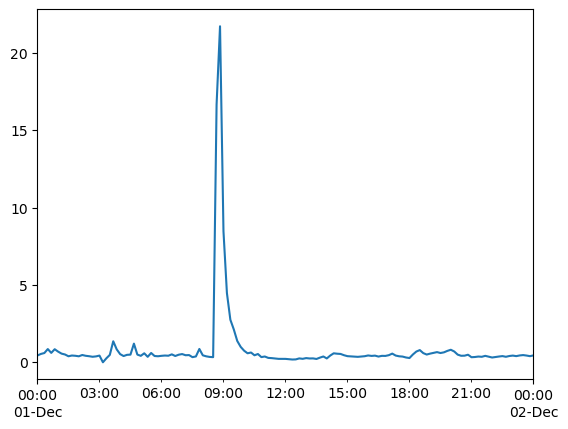

In [44]:
series['HF']['2017-12-01'].plot()